In [1]:
import pandas as pd
from tqdm import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from os.path import join
from copy import deepcopy
from functools import partial
from random import sample
import pandas as pd

# from random import shuffle
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
# Import (tf) model and tokenizer structures from HuggingFace
from transformers import AutoTokenizer, pipeline, DistilBertTokenizer, DistilBertModel

/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from lib.BBData import character_dict, random_state, model_name
from lib.BBDataLoad import load_char_df, get_chatbot_predictions
# from lib.BBVisualizations import BBVisualization, PlotsEnum
from lib.metrics.triplet_nn_classifier import BarneyBotTripletClassifier
from lib.metrics.distil_bert_classifier import DistilBertClassifier
from lib.metrics.frequency import sentence_preprocess, FrequencyClassifier
from lib.visualizations.emotionsradar import EmotionsRadar

# __1 Setup__

Get the characters list and initialize the work folders

In [3]:
characters = list(character_dict.keys())
characters_noDefault = list(character_dict.keys())
characters_noDefault.remove('Default')
base_folder = os.getcwd()
data_folder = join(base_folder, 'Data', 'Characters')
model_folder = join(base_folder, 'models')
out_folder = os.getcwd().join('tmp')
figsize = (8, 8)

## __2 State of the art__

## __2.1 Semantic Classifier__

Let's load the data. For the sake of simplicity we will perform a test just on a small test set

In [59]:
# select the character
character = 'Barney'
# read dataframe
df = pd.read_csv(join(data_folder, character, character.lower()+'_classifier.csv'))
df_train, df_test = train_test_split(df, test_size=0.15)
df_test.head()

,line,character
2591,"Trudy, come on out.",0
23286,Your brain is too predictable associations.,0
23061,"Children, your aunt Lily has always been among...",0
9504,The broken windows?,0
11738,I buy designer clothes and accessories that i ...,0


In [12]:
print('Test size:',len(df_test))

Test size: 4767


__Semantic Classifier__ is meant to labelling of whether sentences belong to a character or not.

It is a binary classifier attempting to recognize if triples of sentences are from a given character or not. We use triples since single sentences may yield too little information to be classified appropriately.

![image](/app/images/Semantic_Classifier.png)

Now we are going to load the model...

In [15]:
# Assert there are enough sentences for the semantic classifier to perform a single evaluation
model_3plet_folder = join(model_folder, 'semantic_classifier', character)
model_3plet = BarneyBotTripletClassifier(character=character, load_path=data_folder)

... and to generate the tripletes that the model should classify.

In [19]:
df_encoded =  model_3plet.get_triplet_df(df_test, 1, random_state)
sentences, y_true = df_encoded['encoded_lines'], df_encoded['character']
df_encoded.head()

Running shuffle 0/1


100%|██████████| 789/789 [00:00<00:00, 3264.48it/s]


,character,encoded_lines
0,0,"[It is French, it's like playing tennis withou..."
1,1,"[Look, Meg, we need to talk., ... I know that ..."
2,1,"[Highest., Really? 'Cause I could swear you fe..."
3,1,"[Dad, look how fast I can run!, Ding, class di..."
4,0,"[Yeah, that's Future Marshall's problem. Let t..."


The dataset of triplets contains aggregations of 3 sentences coming from the original dataset. It is realised in order to get it in a balanced way. This in order to avoid issues in training phase.

In [20]:
print('class 0:', len(y_true[y_true==0]))
print('class 1:', len(y_true[y_true==1]))

class 0: 789
class 1: 789


Then the compute method will perform the classification of a list of sentences, by performing all the permutations in triplettes.

In [21]:
y_pred = []
for s in tqdm(sentences):
     y_pred.append(np.round(
          np.mean(model_3plet.compute(s, character, model_3plet_folder, n_sentences='all')), 0
     ))

100%|██████████| 1578/1578 [07:58<00:00,  3.30it/s]


It performs extremely well against the test set, that is, distinguishing the character’s true line in scripts (label).

Neural chatbot classifier test accuracy: 0.91
Neural chatbot classifier test f1 score: 0.91


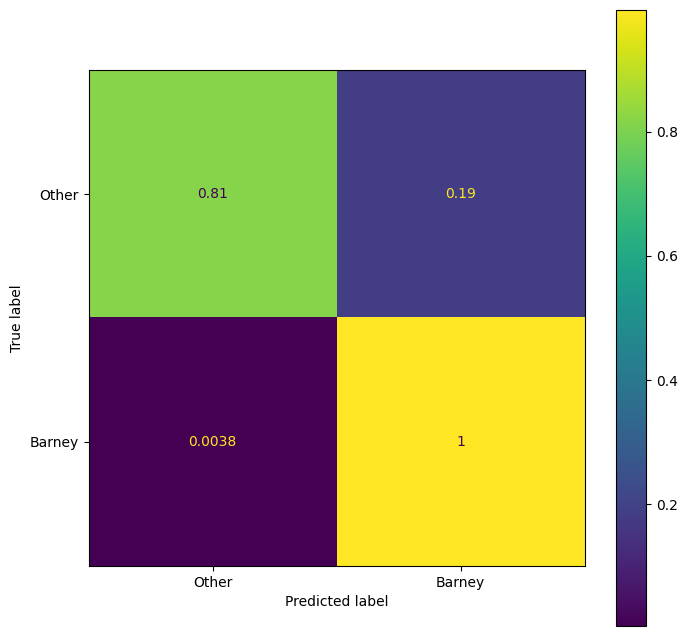

In [23]:
# print the classification report and scores
print('Neural chatbot classifier test accuracy: {:.2f}\nNeural chatbot classifier test f1 score: {:.2f}'.format(
        accuracy_score(y_pred, y_true), f1_score(y_pred, y_true))
     )
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Other', character])
fig, ax = plt.subplots(figsize=figsize)
disp.plot(ax=ax)

### 2.1.2 __Chatbot predictions__

Let's now try to run the experiment on the chatbot predicions

In [60]:
file_name = 'barney_prediction_sampling.json'
# Load tokenizer, and set its padding token to the symbol #, which is removed in preprocessing from all datasets
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=os.path.join(base_folder, "cache"))
tokenizer.pad_token = '#'

In [61]:
chatbot_predictions = get_chatbot_predictions(None, None, file_name, None, character, tokenizer, base_folder)
chatbot_predictions = [tokenizer.decode(s, skip_special_tokens=True) for s in chatbot_predictions]
chatbot_predictions[:5]

Loading predictions from stored file
Loaded predictions from stored file


["Oh, God, you're gonna be in that one.",
 'The Meatball sub.',
 'I called three emergency personnel to help me get out of the apartment.',
 'How much fun is this?',
 "That's it? You're being Barney's best friend?"]

In [62]:
df_test = df_test.reset_index(drop=True)
df_test.head()

,line,character
0,"Trudy, come on out.",0
1,Your brain is too predictable associations.,0
2,"Children, your aunt Lily has always been among...",0
3,The broken windows?,0
4,I buy designer clothes and accessories that i ...,0


In [63]:
j = 0
for i in df_test.index:
    if df_test['character'][i] == 1:
        df_test['line'][i] = chatbot_predictions[j]
        j += 1
    if len(chatbot_predictions) == j: 
        break
df_test = df_test[:j]
df_test

/tmp/ipykernel_12283/565759476.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['line'][i] = chatbot_predictions[j]


,line,character
0,"Trudy, come on out.",0
1,Your brain is too predictable associations.,0
2,"Children, your aunt Lily has always been among...",0
3,The broken windows?,0
4,I buy designer clothes and accessories that i ...,0
...,...,...
517,"Well, off to meet Steph. We're adrenaline junk...",0
518,"And, look, some good came out of all this.",0
519,I don't know why I was so scared of this. Pret...,0
520,"Nah, it's Kraft Croft night: mac and cheese an...",0


In [64]:
df_encoded =  model_3plet.get_triplet_df(df_test, 1, random_state)
sentences, y_true = df_encoded['encoded_lines'], df_encoded['character']
df_encoded.head()

Running shuffle 0/1


100%|██████████| 81/81 [00:00<00:00, 7787.17it/s]


,character,encoded_lines
0,0,"[Children? Why..., Vans have doors-- let me se..."
1,0,"[Five American bucks., No, I don't!...Not incr..."
2,1,"[Oh, we are., We're going to the Cafe Bon Jovi..."
3,1,"[You're such a sweet guy., Whoa, whoa, you're ..."
4,1,"[You're not gonna bang, are you?, Oh, my God!,..."


In [65]:
print('class 0:', len(y_true[y_true==0]))
print('class 1:', len(y_true[y_true==1]))

class 0: 81
class 1: 81


In [66]:
y_pred = []
for s in tqdm(sentences):
     y_pred.append(np.round(
          np.mean(model_3plet.compute(s, character, model_3plet_folder, n_sentences='all')), 0
     ))

100%|██████████| 162/162 [00:51<00:00,  3.17it/s]


The classifier here instead suffers from huge variance when working on sentences generated from chatbots (chatbot). Indeed the problem to recognize the chatbot is still very hard.

Neural chatbot classifier test accuracy: 0.60
Neural chatbot classifier test f1 score: 0.50


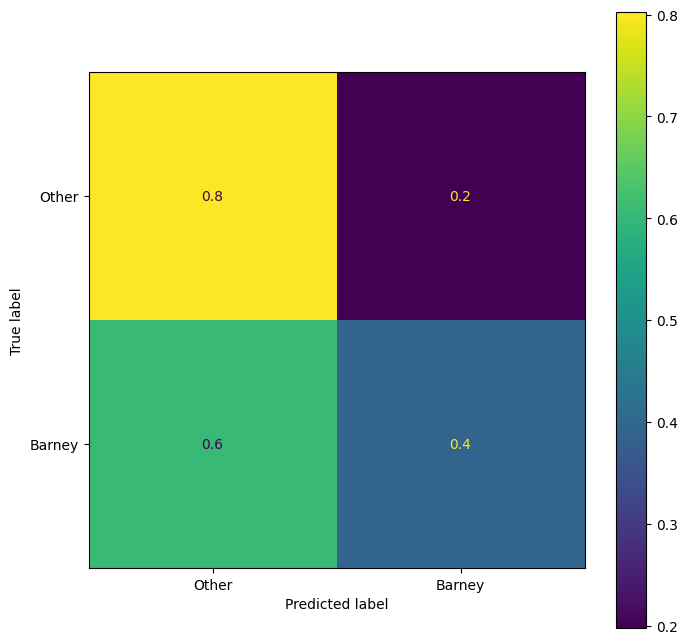

In [67]:
# print the classification report and scores
print('Neural chatbot classifier test accuracy: {:.2f}\nNeural chatbot classifier test f1 score: {:.2f}'.format(
        accuracy_score(y_pred, y_true), f1_score(y_pred, y_true))
     )
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Other', character])
fig, ax = plt.subplots(figsize=figsize)
disp.plot(ax=ax)

We attempted also in comparing two different characters using the classifier of the first character usually results in a correct guess and in greater variance for the wrong one, but not always. For the sake of simplicity we will not go in deeper details for what concern this model.

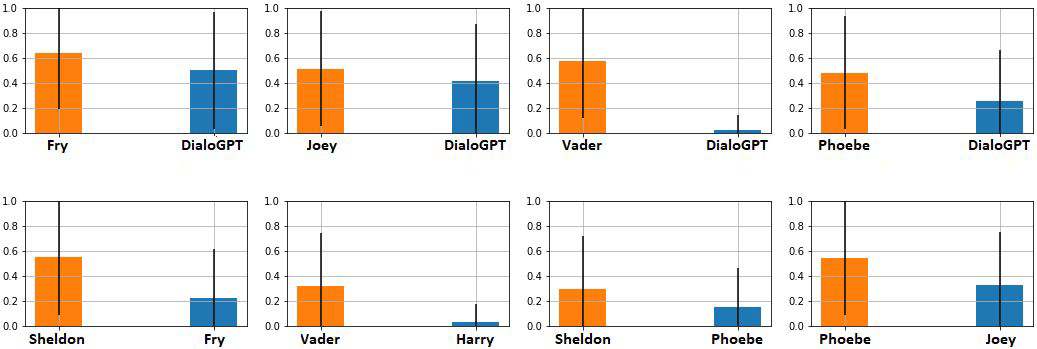

## __2.2 Emotion Classifier__

Now we are going to take a pre-trained neural emotion classifier and to use it to classify sentences from a character. More precisely we consider the average over the sentences as the emotion “fingerprint” of that character. We tried many variations to improve previous
results: different model, threshold or do a count of the best emotions only

In [5]:
# Load tokenizer, and set its padding token to the symbol #, which is removed in preprocessing from all datasets
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=os.path.join(base_folder, "cache"))
tokenizer.pad_token = '#'

Here we load the dataset...

In [6]:
# select the character
character = 'Barney'
file_name = character.lower()+'_prediction_sampling.json'
# read dataframe
df = pd.read_csv(os.path.join(data_folder, character, f'{character}.csv'))
chatbot_predictions = get_chatbot_predictions(None, None, file_name, None, character, tokenizer, base_folder)
chatbot_predictions = [tokenizer.decode(s, skip_special_tokens=True) for s in chatbot_predictions]
sentences = df['response'].to_list()

Loading predictions from stored file
Loaded predictions from stored file


... and load the [emotion classifier](https://huggingface.co/bhadresh-savani/distilbert-base-uncased-emotion)

In [7]:
emotion_classifier = pipeline("text-classification", model='bhadresh-savani/distilbert-base-uncased-emotion',
                              return_all_scores=True)

/usr/local/lib/python3.8/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [8]:
result = {'score': {}, 'std': {}}
output = emotion_classifier(sentences)

In [9]:
# Initialize lists of scores for each emotion
for emotion_dict in output[0]:
    result['score'][emotion_dict['label']] = []
# For each sentence...
for elem in output:
    # Append scores to the scores list for each emotion
    for emotion_dict in elem:
        result['score'][emotion_dict['label']].append(emotion_dict['score'])
# For each emotion label...
for emotion_dict in output[0]:
    # Append emotion as a separate entry in the result dictionary
    emotion = emotion_dict['label']
    # Transform lists of scores into single std and mean values
    result['std'][emotion] = np.std(np.array(result['score'][emotion]))
    result['score'][emotion] = np.mean(np.array(result['score'][emotion]))
# Return a dictionary with lists for labels, avg scores and stds, in corresponding order
result['label'] = list(result['score'].keys())
result['score'] = list(result['score'].values())
result['std'] = list(result['std'].values())
result

{'score': [0.0864908300056685,
  0.4031424635679138,
  0.02963537962765485,
  0.3774144738739534,
  0.09106193038221658,
  0.012254922831190916],
 'std': [0.2300232808966156,
  0.4065923637508026,
  0.13999348448357918,
  0.3678006118831381,
  0.1880018394884175,
  0.08060208802110608],
 'label': ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']}

In [10]:
emotions = result['label']
labels = result['score']

Now let's compute the emotion scores on the chatbot responses

In [11]:
result = {'score': {}, 'std': {}}
output = emotion_classifier(chatbot_predictions)

In [12]:
# Initialize lists of scores for each emotion
for emotion_dict in output[0]:
    result['score'][emotion_dict['label']] = []
# For each sentence...
for elem in output:
    # Append scores to the scores list for each emotion
    for emotion_dict in elem:
        result['score'][emotion_dict['label']].append(emotion_dict['score'])
# For each emotion label...
for emotion_dict in output[0]:
    # Append emotion as a separate entry in the result dictionary
    emotion = emotion_dict['label']
    # Transform lists of scores into single std and mean values
    result['std'][emotion] = np.std(np.array(result['score'][emotion]))
    result['score'][emotion] = np.mean(np.array(result['score'][emotion]))
# Return a dictionary with lists for labels, avg scores and stds, in corresponding order
result['label'] = list(result['score'].keys())
result['score'] = list(result['score'].values())
result['std'] = list(result['std'].values())
result

{'score': [0.0983512363524207,
  0.3969137964258539,
  0.02341386576298998,
  0.39206532480417233,
  0.07623960344833458,
  0.0130161681734263],
 'std': [0.2532222810674703,
  0.4110804271839151,
  0.12311367652639678,
  0.37927834035921104,
  0.16481737077036354,
  0.09169673662333819],
 'label': ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']}

In [13]:
predictions = result['score']

Results on emotion analysis were, unfortunately, disappointing: although single sentences can be classified more or less correctly, their average quickly degrades to pretty much the same output. We have found no significant differences with respect to the dataset taken under consideration.

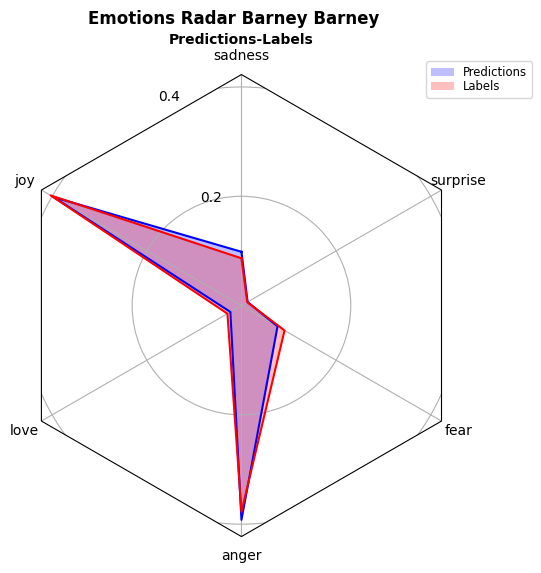

In [14]:
EmotionsRadar(emotions, predictions, labels, character).plotEmotionsRadar('Emotions Radar '+character)

Let's repeat the experiment with another character, maybe with a different personality.

Results are underwhelming: there is general overlapping between all models and correlations between emotion vectors of different characters is almost always close to 1.

Moreover __strong bias__ on emotions of `joy` and `anger`, sometimes sadness.

Loading predictions from stored file
Loaded predictions from stored file


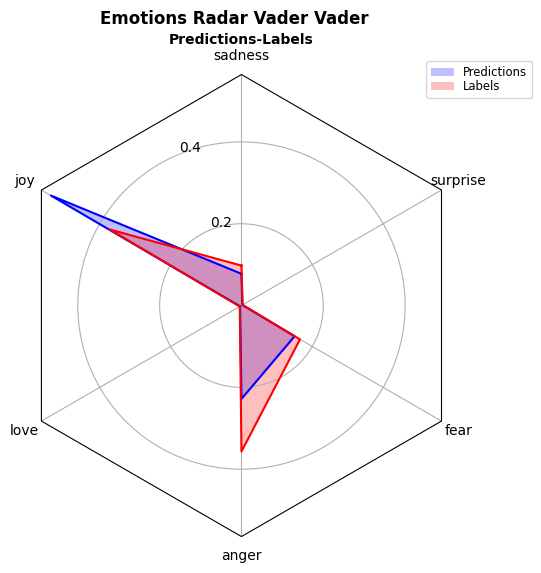

In [15]:
# select the character
character = 'Vader'
file_name = character.lower()+'_prediction_sampling.json'
# read dataframe
df = pd.read_csv(os.path.join(data_folder, character, f'{character}.csv'))
sentences = df['response'].to_list()
chatbot_predictions = get_chatbot_predictions(None, None, file_name, None, character, tokenizer, base_folder)
chatbot_predictions = [tokenizer.decode(s, skip_special_tokens=True) for s in chatbot_predictions]

result = {'score': {}, 'std': {}}
output = emotion_classifier(sentences)

# Initialize lists of scores for each emotion
for emotion_dict in output[0]:
    result['score'][emotion_dict['label']] = []
# For each sentence...
for elem in output:
    # Append scores to the scores list for each emotion
    for emotion_dict in elem:
        result['score'][emotion_dict['label']].append(emotion_dict['score'])
# For each emotion label...
for emotion_dict in output[0]:
    # Append emotion as a separate entry in the result dictionary
    emotion = emotion_dict['label']
    # Transform lists of scores into single std and mean values
    result['std'][emotion] = np.std(np.array(result['score'][emotion]))
    result['score'][emotion] = np.mean(np.array(result['score'][emotion]))
# Return a dictionary with lists for labels, avg scores and stds, in corresponding order
result['label'] = list(result['score'].keys())
result['score'] = list(result['score'].values())
result['std'] = list(result['std'].values())

# store emotions keys
emotions = result['label']
# store emotions score on script dataset
labels = result['score']

result = {'score': {}, 'std': {}}
output = emotion_classifier(chatbot_predictions)

# Initialize lists of scores for each emotion
for emotion_dict in output[0]:
    result['score'][emotion_dict['label']] = []
# For each sentence...
for elem in output:
    # Append scores to the scores list for each emotion
    for emotion_dict in elem:
        result['score'][emotion_dict['label']].append(emotion_dict['score'])
# For each emotion label...
for emotion_dict in output[0]:
    # Append emotion as a separate entry in the result dictionary
    emotion = emotion_dict['label']
    # Transform lists of scores into single std and mean values
    result['std'][emotion] = np.std(np.array(result['score'][emotion]))
    result['score'][emotion] = np.mean(np.array(result['score'][emotion]))
# Return a dictionary with lists for labels, avg scores and stds, in corresponding order
result['label'] = list(result['score'].keys())
result['score'] = list(result['score'].values())
result['std'] = list(result['std'].values())

# store predictions
predictions = result['score']

# plot the emotion radar
EmotionsRadar(emotions, predictions, labels, character).plotEmotionsRadar('Emotions Radar '+character)

## __2.3 Frequency Chatbot Classifier__

Prepare the dataset for `Frequency Classifier`. 

In this case we need a dictionary built as following: 
$$\mathbb{D}=\{c: \tilde{D}_c\} \hspace{1cm}\forall c \in C$$
this is a dictionary for which each key corresponds to the name of a character with its related value asssociated which is instead the list of o its script lines, preprocessed.

In [20]:
# prepare the dataset of all documents
character_docs = dict()
# foreach character in ours dataset
for character in characters:
    if character == 'Default':
        # read Default dataset and sample 0.02 fraction of the whole dataset
        df = pd.read_csv(os.path.join(data_folder, character, f'{character}.tsv'), 
                         names=[character, 'response'], sep='\t')
        df = df.sample(frac=0.02, random_state=random_state)
        df['response'] = df['response'].apply(lambda x: x[3:])
        df[character] = df[character].apply(lambda x: x[3:])
    else:
        # read other dataset 
        df = pd.read_csv(os.path.join(data_folder, character, f'{character}.csv'))
    # convert dataframes to list
    tmp_list = df['response'].tolist()
    # attach the list to the dictionary of documents of character
    character_docs[character] = tmp_list

In [7]:
# preprocess datasets
character_docs_prepr = deepcopy(character_docs)
for character in characters:
    for i in tqdm(range(len(character_docs[character]))):
        sentence, relevant = sentence_preprocess(character_docs[character][i])
        if relevant:
            character_docs_prepr[character][i] = sentence

100%|██████████| 14747/14747 [00:04<00:00, 3589.96it/s]


In [10]:
# test size for splitting
test_size = 0.33
# prepare the dictionaries of train and set
character_docs_train = {}
character_docs_test = {}
n_docs = 0
# for each character in ours data
for c in characters:
    # shuffle data
    character_docs_prepr[c] = shuffle(character_docs_prepr[c], random_state=random_state)
    # split the dataset in train e test set
    end_idx = int(len(character_docs_prepr[c]) * test_size)
    character_docs_train[c] = character_docs_prepr[c][end_idx:]
    n_docs += len(character_docs_prepr[c][end_idx:])
    character_docs_test[c] = character_docs_prepr[c][:end_idx]

In [11]:
# takes the list of characters without Default
characters_noDefault = characters.copy()
characters_noDefault.remove('Default')
# load dataset in hugging face dictionary model
character_hg = {c:None for c in characters_noDefault}
for c in characters_noDefault:
    # extract the character checkpoint
    character_checkpoint = join(data_folder, c, character_dict[c]['checkpoint_folder'])
    # load the dataset dict of each character
    character_hg[c] = load_char_df(c, base_folder)

Found cached dataset csv (/app/notebooks/cache/csv/default-dd07b0e7e3df8359/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at /app/notebooks/cache/csv/default-dd07b0e7e3df8359/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-c7d3ec6662680d64.arrow and /app/notebooks/cache/csv/default-dd07b0e7e3df8359/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-1dc91bae0d09a1f5.arrow
Loading cached split indices for dataset at /app/notebooks/cache/csv/default-dd07b0e7e3df8359/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-c3793660279940c7.arrow and /app/notebooks/cache/csv/default-dd07b0e7e3df8359/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-f96aafc4d74714b6.arrow
Found cached dataset csv (/app/notebooks/cache/csv/default-f764b657cc592952/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at /app/notebooks/cache/csv/default-f764b657cc592952/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-f33ed36c10b4cc15.arrow and /app/notebooks/cache/csv/default-f764b657cc592952/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-0d25fe4cff24b6d8.arrow
Loading cached split indices for dataset at /app/notebooks/cache/csv/default-f764b657cc592952/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-24eef478de0c1383.arrow and /app/notebooks/cache/csv/default-f764b657cc592952/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-e905c0428b937ac5.arrow
Found cached dataset csv (/app/notebooks/cache/csv/default-095a0ca481b515c5/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at /app/notebooks/cache/csv/default-095a0ca481b515c5/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-30e8f9fa27404050.arrow and /app/notebooks/cache/csv/default-095a0ca481b515c5/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-80fb22e93debfa0d.arrow
Loading cached split indices for dataset at /app/notebooks/cache/csv/default-095a0ca481b515c5/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-5abe9faada8ea36b.arrow and /app/notebooks/cache/csv/default-095a0ca481b515c5/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-0c2954af190ebfa2.arrow
Found cached dataset csv (/app/notebooks/cache/csv/default-b4222c58ca1f28b4/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at /app/notebooks/cache/csv/default-b4222c58ca1f28b4/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-9b0899ca43c26ced.arrow and /app/notebooks/cache/csv/default-b4222c58ca1f28b4/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-e2ae211b7013b878.arrow
Loading cached split indices for dataset at /app/notebooks/cache/csv/default-b4222c58ca1f28b4/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-98c63d42105f35bf.arrow and /app/notebooks/cache/csv/default-b4222c58ca1f28b4/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-11d0ce00f9c40318.arrow
Found cached dataset csv (/app/notebooks/cache/csv/default-5e5168f7d8ab1f87/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at /app/notebooks/cache/csv/default-5e5168f7d8ab1f87/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-6acf41cc747c5497.arrow and /app/notebooks/cache/csv/default-5e5168f7d8ab1f87/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-a31613a92ea4d34b.arrow
Loading cached split indices for dataset at /app/notebooks/cache/csv/default-5e5168f7d8ab1f87/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-4b8e13a055f9e92d.arrow and /app/notebooks/cache/csv/default-5e5168f7d8ab1f87/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-278e55854694342e.arrow
Found cached dataset csv (/app/notebooks/cache/csv/default-63cf32be541b1cf6/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at /app/notebooks/cache/csv/default-63cf32be541b1cf6/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-631578260ee6077f.arrow and /app/notebooks/cache/csv/default-63cf32be541b1cf6/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-eaed2fbf965b5546.arrow
Loading cached split indices for dataset at /app/notebooks/cache/csv/default-63cf32be541b1cf6/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-5926ef784682cfbd.arrow and /app/notebooks/cache/csv/default-63cf32be541b1cf6/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-8c652d76529dfe6a.arrow
Found cached dataset csv (/app/notebooks/cache/csv/default-d720ea12879cd835/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at /app/notebooks/cache/csv/default-d720ea12879cd835/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-0ccef7e72c7d6cd6.arrow and /app/notebooks/cache/csv/default-d720ea12879cd835/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-94c6c691118c1b00.arrow
Loading cached split indices for dataset at /app/notebooks/cache/csv/default-d720ea12879cd835/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-4f01e0ab00bb9adb.arrow and /app/notebooks/cache/csv/default-d720ea12879cd835/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-c38ed1090ba9a197.arrow
Found cached dataset csv (/app/notebooks/cache/csv/default-b6aaaae5f5af64a1/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at /app/notebooks/cache/csv/default-b6aaaae5f5af64a1/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-eebdd3698dff8a7f.arrow and /app/notebooks/cache/csv/default-b6aaaae5f5af64a1/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-667871d791919918.arrow
Loading cached split indices for dataset at /app/notebooks/cache/csv/default-b6aaaae5f5af64a1/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-ae70a2b421f0121b.arrow and /app/notebooks/cache/csv/default-b6aaaae5f5af64a1/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-874c8b49bfbdc50f.arrow


Look at the problem as an Information Retrieval (IR) approach. The goal is to return the documents (w.r.t the train character script lines) ordered according to their similarity with respect to the query (w.r.t the chatbot responses).

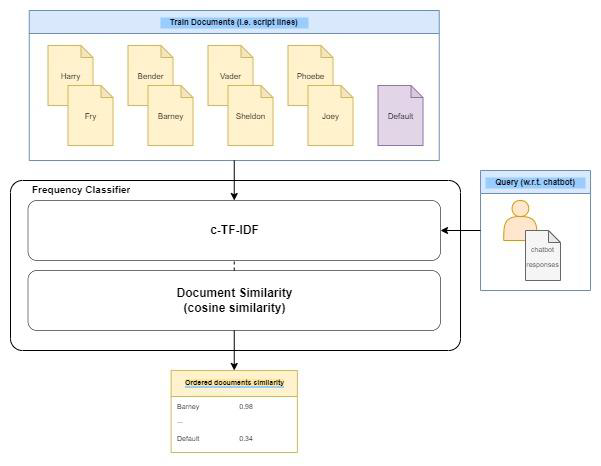

In [12]:
# Initialize and train the FrequencyClassifier
ctfidf_classifier = FrequencyClassifier(characters, mode='c-tf-idf')
ctfidf_classifier.train(list(character_docs_train.values()))

c-TF-IDF classifier test accuracy: 1.00
c-TF-IDF classifier test f1 score: 1.00


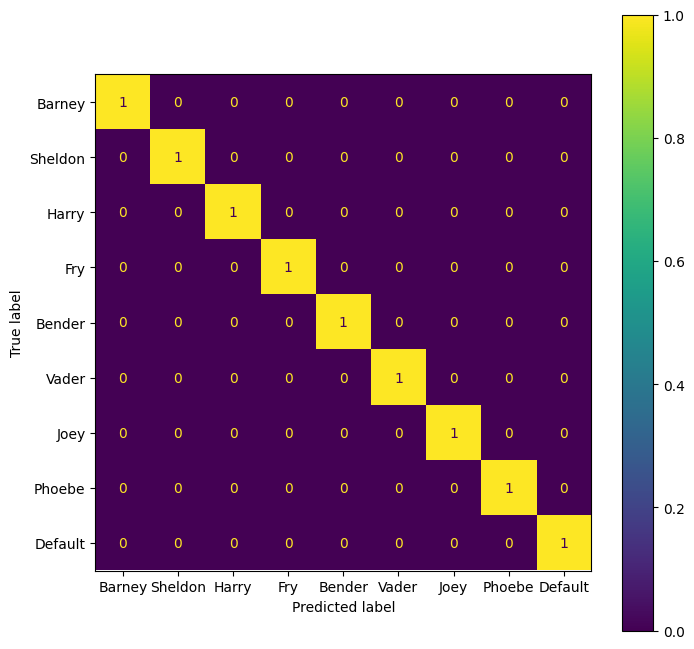

In [13]:
# real y value 
y_true = [characters.index(c) for c in characters]
# compute y predicted by the model
y_pred = []
raw_predictions = {c:[] for c in characters}
for c in characters:
    # compute the prediction
    prediction = ctfidf_classifier.predict(character_docs_test[c])
    raw_predictions[c].append(prediction)
    # extract the argmax of the prediction which is the index of the character predicted
    y_pred.append(np.argmax(list(prediction.values())))

# print the classification report and scores
print('c-TF-IDF classifier test accuracy: {:.2f}\nc-TF-IDF classifier test f1 score: {:.2f}'.format(
        accuracy_score(y_pred, y_true), f1_score(y_pred, y_true, average='macro'))
     )
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=characters)
fig, ax = plt.subplots(figsize=figsize)
disp.plot(ax=ax)

In [14]:
# divide a list in sublists of equal size of elements
def subgroup_list(l, n):
    return [l[e:e+n] for e in range(0, len(l), n)]

In order to understand the real behaviour of this model, we will divide the test set in lists of subgroups of 3 and 10 consecutive lines, to add a level of complexity.

Subgroups of 3 consecutive lines

c-TF-IDF classifier test accuracy: 0.70
c-TF-IDF classifier test f1 score: 0.65


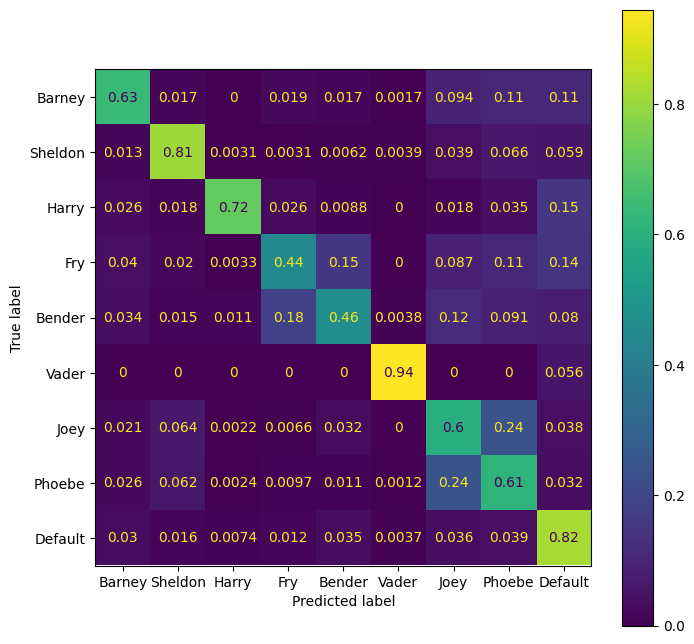

In [15]:
# 3 consecutive lines
m = 3
# real y value 
y_true = [characters.index(c) for c in characters for d in subgroup_list(character_docs_test[c], m)]
# compute y predicted by the model
y_pred = []
raw_predictions = {c:[] for c in characters}
for c in characters:
    # document d to predict compose by 3 consecutive lines
    for d in subgroup_list(character_docs_test[c], m):
        # compute the prediction
        prediction = ctfidf_classifier.predict(d)
        raw_predictions[c].append(prediction)
        # extract the argmax of the prediction which is the index of the character predicted
        y_pred.append(np.argmax(list(prediction.values())))

# print the classification report and scores
print('c-TF-IDF classifier test accuracy: {:.2f}\nc-TF-IDF classifier test f1 score: {:.2f}'.format(
        accuracy_score(y_pred, y_true), f1_score(y_pred, y_true, average='macro'))
     )
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=characters)
fig, ax = plt.subplots(figsize=figsize)
disp.plot(ax=ax)

c-TF-IDF classifier test accuracy: 0.91
c-TF-IDF classifier test f1 score: 0.90


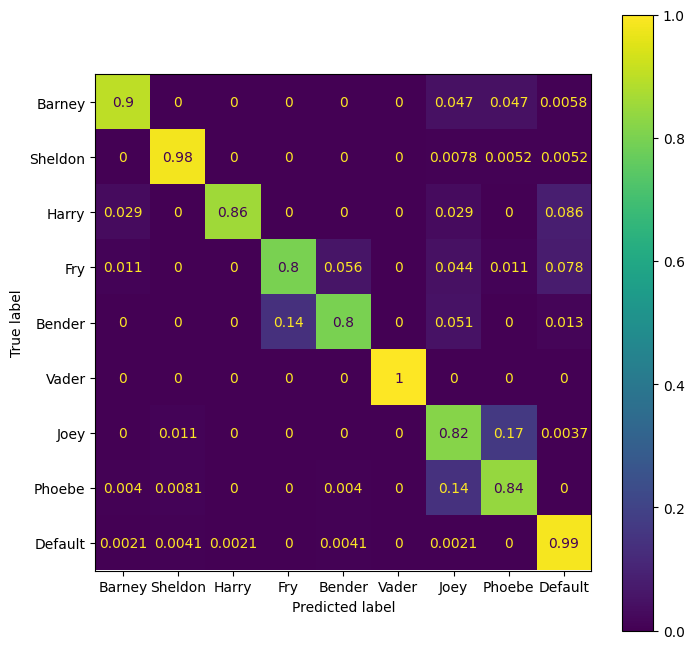

In [16]:
# 10 consecutive lines
m = 10
# real y value 
y_true = [characters.index(c) for c in characters for d in subgroup_list(character_docs_test[c], m)]
# compute y predicted by the model
y_pred = []
raw_predictions = {c:[] for c in characters}
for c in characters:
    # document d to predict compose by 3 consecutive lines
    for d in subgroup_list(character_docs_test[c], m):
        # compute the prediction
        prediction = ctfidf_classifier.predict(d)
        raw_predictions[c].append(prediction)
        # extract the argmax of the prediction which is the index of the character predicted
        y_pred.append(np.argmax(list(prediction.values())))

# print the classification report and scores
print('c-TF-IDF classifier test accuracy: {:.2f}\nc-TF-IDF classifier test f1 score: {:.2f}'.format(
        accuracy_score(y_pred, y_true), f1_score(y_pred, y_true, average='macro'))
     )
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=characters)
fig, ax = plt.subplots(figsize=figsize)
disp.plot(ax=ax)

Thus as we can, the amount of sentences in queries can largely affect the evaluation, increasing the confidence in deciding which should be the character in prediction

It can be noticed also that the problem seems to be much difficult for distinguishing characters coming from a common tv show (e.g. _Fry_-_Bender_ from _Futurama_ and _Joey_-_Phoebe_ from _Friends_). A possible explaination to this results could come from the authors's script style of a given tv show, or by common topics present in the characters lines. 

### 2.3.2 __Chatbot predictions__

Test the model on the chatbots responses and check the predictions of the Frequency classifier

In [17]:
file_name = 'barney_prediction_sampling.json'
# Load tokenizer, and set its padding token to the symbol #, which is removed in preprocessing from all datasets
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=os.path.join(base_folder, "cache"))
tokenizer.pad_token = '#'

In [21]:
# prepare the dataset of all documents
chatbot_docs = dict()
# foreach character in ours dataset
for character in characters_noDefault:
    file_name = character.lower() + '_prediction_sampling.json'
    # read other dataset 
    chatbot_predictions = get_chatbot_predictions(None, None, file_name, None, character, tokenizer, base_folder)
    # attach the list to the dictionary of documents of character
    chatbot_docs[character] = [tokenizer.decode(s, skip_special_tokens=True) for s in chatbot_predictions]

Loading predictions from stored file
Loaded predictions from stored file
Loading predictions from stored file
Loaded predictions from stored file
Loading predictions from stored file
Loaded predictions from stored file
Loading predictions from stored file
Loaded predictions from stored file
Loading predictions from stored file
Loaded predictions from stored file
Loading predictions from stored file
Loaded predictions from stored file
Loading predictions from stored file
Loaded predictions from stored file
Loading predictions from stored file
Loaded predictions from stored file


In [23]:
# preprocess datasets
chatbot_docs_prepr = deepcopy(chatbot_docs)
for character in characters_noDefault:
    for i in tqdm(range(len(chatbot_docs[character]))):
        sentence, relevant = sentence_preprocess(chatbot_docs[character][i])
        if relevant:
            chatbot_docs_prepr[character][i] = sentence

100%|██████████| 751/751 [00:00<00:00, 1906.39it/s]


In [24]:
# initialize the frequency classifier and train over the documents
tfidf_classifier = FrequencyClassifier(characters, mode='c-tf-idf')
tfidf_classifier.train(list(character_docs.values()))

c-TF-IDF classifier test accuracy: 0.72
c-TF-IDF classifier test f1 score: 0.65


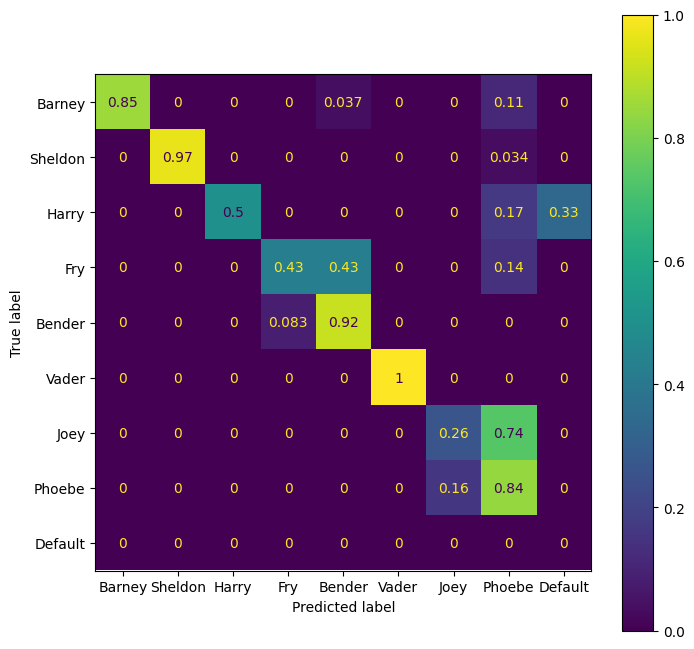

In [27]:
# size of each subgroup
m = 20

y_true = []
y_pred = []

for c in characters_noDefault:
    # Takes a subset of the testset as sample question
    for d in subgroup_list(chatbot_docs_prepr[c], m):
        # compute the prediction
        prediction = ctfidf_classifier.predict(d)
        # extract the argmax of the prediction which is the index of the character predicted
        y_pred.append(np.argmax(list(prediction.values())))
        y_true.append(characters_noDefault.index(c))

# print the classification report and scores
print('c-TF-IDF classifier test accuracy: {:.2f}\nc-TF-IDF classifier test f1 score: {:.2f}'.format(
        accuracy_score(y_pred, y_true), f1_score(y_pred, y_true, average='macro'))
     )
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=characters)
fig, ax = plt.subplots(figsize=figsize)
disp.plot(ax=ax)

By the way results are very surprising also with the chatbot responses, but the problem of characters coming from common tv show is still there, confirming the complexity of this task.

## __2.4 DistilBERT Classifier__

In [6]:
# prepare the dataset of all documents
character_docs = dict()
# foreach character in ours dataset
for character in characters:
    if character == 'Default':
        # read Default dataset and sample 0.02 fraction of the whole dataset
        df = pd.read_csv(os.path.join(data_folder, character, f'{character}.tsv'), 
                         names=[character, 'response'], sep='\t')
        df = df.sample(frac=0.02, random_state=random_state)
        df['response'] = df['response'].apply(lambda x: x[3:])
        df[character] = df[character].apply(lambda x: x[3:])
    else:
        # read other dataset 
        df = pd.read_csv(os.path.join(data_folder, character, f'{character}.csv'))
    # convert dataframes to list
    tmp_list = df['response'].tolist()
    # attach the list to the dictionary of documents of character
    character_docs[character] = tmp_list

In [7]:
# test size for splitting
test_size = 0.33
# prepare the dictionaries of train and set
character_docs_train = {}
character_docs_test = {}
n_docs = 0
# for each character in ours data
for c in characters:
    # shuffle data
    character_docs[c] = shuffle(character_docs[c], random_state=random_state)
    # split the dataset in train e test set
    end_idx = int(len(character_docs[c]) * test_size)
    character_docs_train[c] = character_docs[c][end_idx:]
    n_docs += len(character_docs[c][end_idx:])
    character_docs_test[c] = character_docs[c][:end_idx]

In [4]:
# embedder_path = join(os.getcwd(), 'models', 'new_distilbert_embedder')
embedder_path = join(os.getcwd(), 'models', 'distilbert_embedder')
classifier_path = join(os.getcwd(), 'models', 'distilbert_classifier')

In [5]:
# TODO: fare distillbert
distilbert_model = DistilBertClassifier(embedder_path=embedder_path, use_cuda=False, from_pretrained = True)

In [9]:
distilbert_model.test(character_docs_test['Barney'][:20], ['Barney' for _ in range(20)])

NotFittedError: This KNeighborsClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [8]:
# distilbert_model.train(
#     characters_path = data_folder,
#     model_path = embedder_path,
#     train_embedder = True,
#     verbose = True,
#     patience = 5,
#     test=True)

In [ ]:
# distilbert_model.compute(sentences=character_docs['Bender'][50:51], verbose=True, count_neighbors=False)

In [ ]:

# y_pred = []
# for s in chatbot_docs:
#     y_pred.append(distilbert_model.compute([s]))
# # print the classification report and scores
# print('DistilBERT classifier test accuracy: {:.2f}\nDistilBERT classifier test f1 score: {:.2f}'.format(
#         accuracy_score(y_pred, y_true), f1_score(y_pred, y_true, average='macro'))
#      )
# cm = confusion_matrix(y_true, y_pred, normalize='true')
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=characters_noDefault)
# fig, ax = plt.subplots(figsize=figsize)
# disp.plot(ax=ax)